## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from lane import *
%matplotlib qt

def calibrate_camera():
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob('camera_cal/calibration*.jpg')

    # Step through the list and search for chessboard corners
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
            cv2.imshow('img',img)
            cv2.waitKey(500)

    cv2.destroyAllWindows()
    
    return objpoints, imgpoints

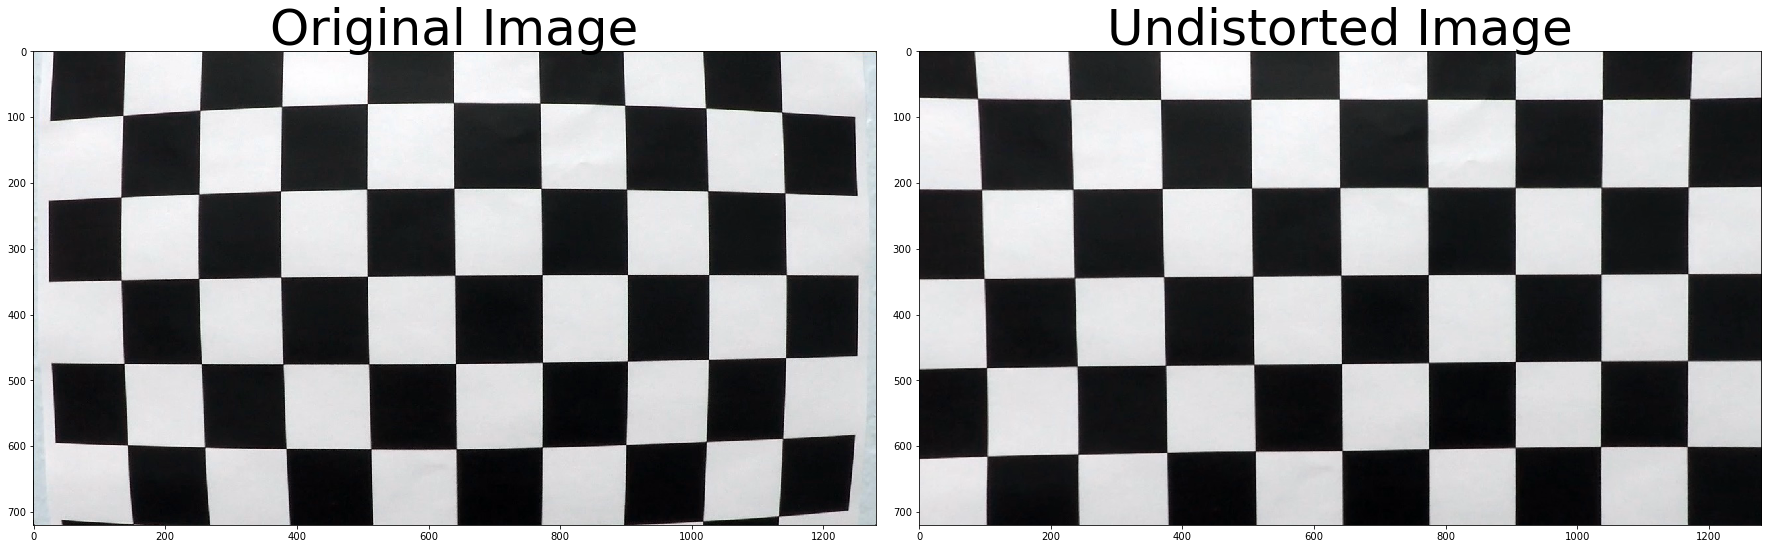

In [2]:
# Calibrate camera using 20 chessboard images
objpoints, imgpoints = calibrate_camera()
# Test the computed calibration matrix on a chessboard image
img = cv2.imread('camera_cal/calibration1.jpg')
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, (img.shape[1], img.shape[0]), None, None)
undist = cv2.undistort(img, mtx, dist, None, mtx)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undist)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Apply distortion correction on a raw road image

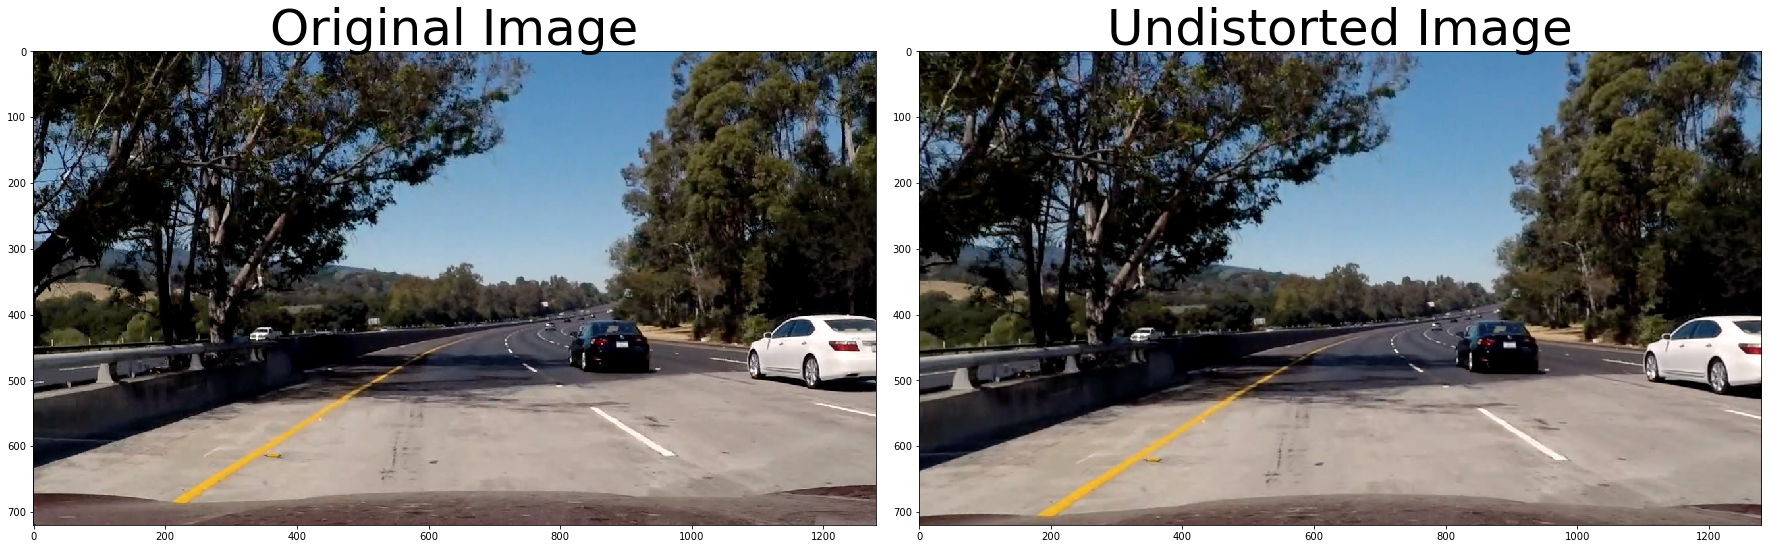

In [3]:
img = mpimg.imread('test_images/test5.jpg')
gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, (gray.shape[1], gray.shape[0]), None, None)
undist = cv2.undistort(img, mtx, dist, None, mtx)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undist)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Use color transforms, gradients, etc., to create a thresholded binary image.

In [4]:
def cal_binary(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    
    binary = s_binary | sxbinary
    # Stack each channel (for visualization)
    color_binary = np.dstack(( np.zeros_like(s_binary), s_binary, sxbinary)) * 255
    return binary, color_binary

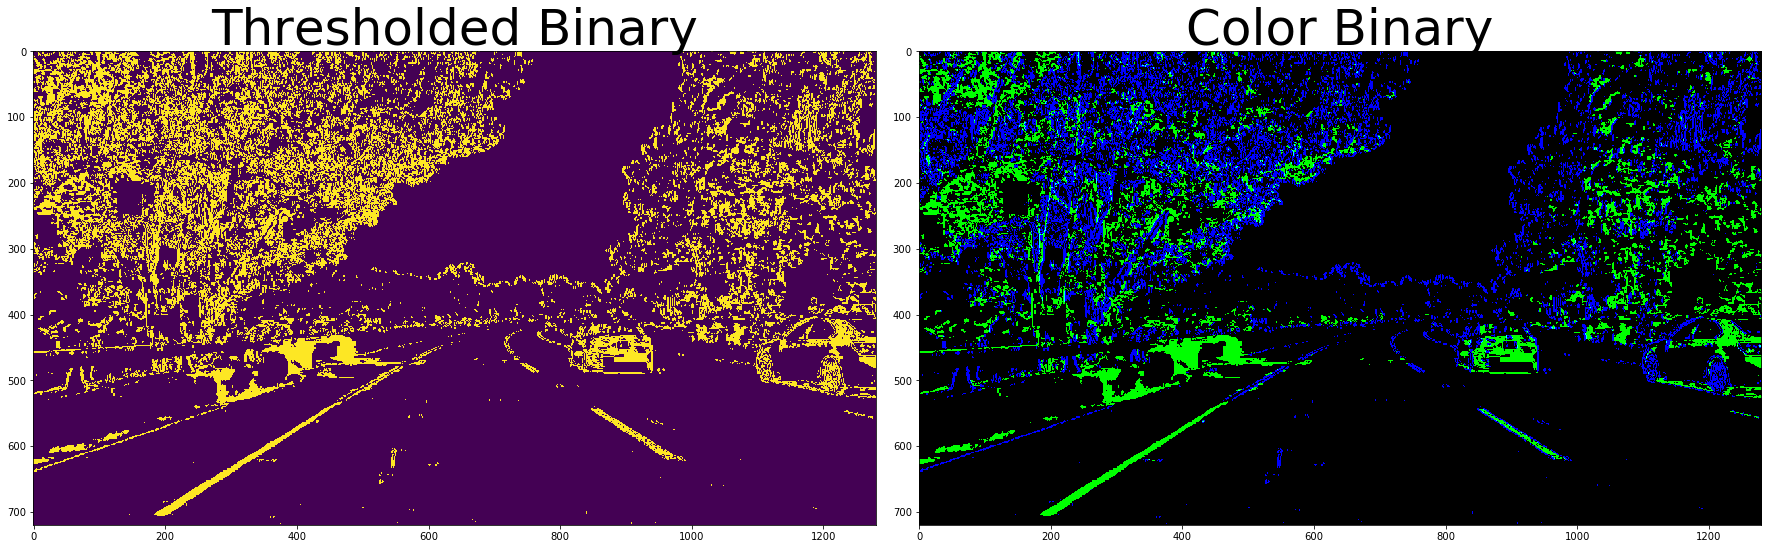

In [5]:
binary, color_binary = cal_binary(undist, s_thresh=(170, 255), sx_thresh=(20, 100))

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(binary)
ax1.set_title('Thresholded Binary', fontsize=50)
ax2.imshow(color_binary)
ax2.set_title('Color Binary', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Apply a perspective transform to rectify binary image ("birds-eye view").

In [6]:
def transform(img):
    img_draw = img.copy()
    xsize = img.shape[1]
    ysize = img.shape[0]

    src = np.array(
                [[xsize/2 - 55,ysize*0.63],
                 [xsize/2 + 55,ysize*0.63],
                 [xsize-150,ysize],
                 [200,ysize]], dtype=np.float32)

    dst = np.array(
                [[xsize/5,0],
                 [xsize-xsize/5,0],
                 [xsize-xsize/5,ysize],
                 [xsize/5,ysize]], dtype=np.float32)

    # Visualize src points
    if len(img.shape) <= 2:
        color = 1
    else:
        color = [255, 0, 0]
    cv2.line(img_draw, tuple(src[0]), tuple(src[1]), color=color, thickness=2)
    cv2.line(img_draw, tuple(src[1]), tuple(src[2]), color=color, thickness=2)
    cv2.line(img_draw, tuple(src[2]), tuple(src[3]), color=color, thickness=2)
    cv2.line(img_draw, tuple(src[3]), tuple(src[0]), color=color, thickness=2)

    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, (xsize,ysize), flags=cv2.INTER_LINEAR)
    return warped, img_draw

(720, 1280, 3)


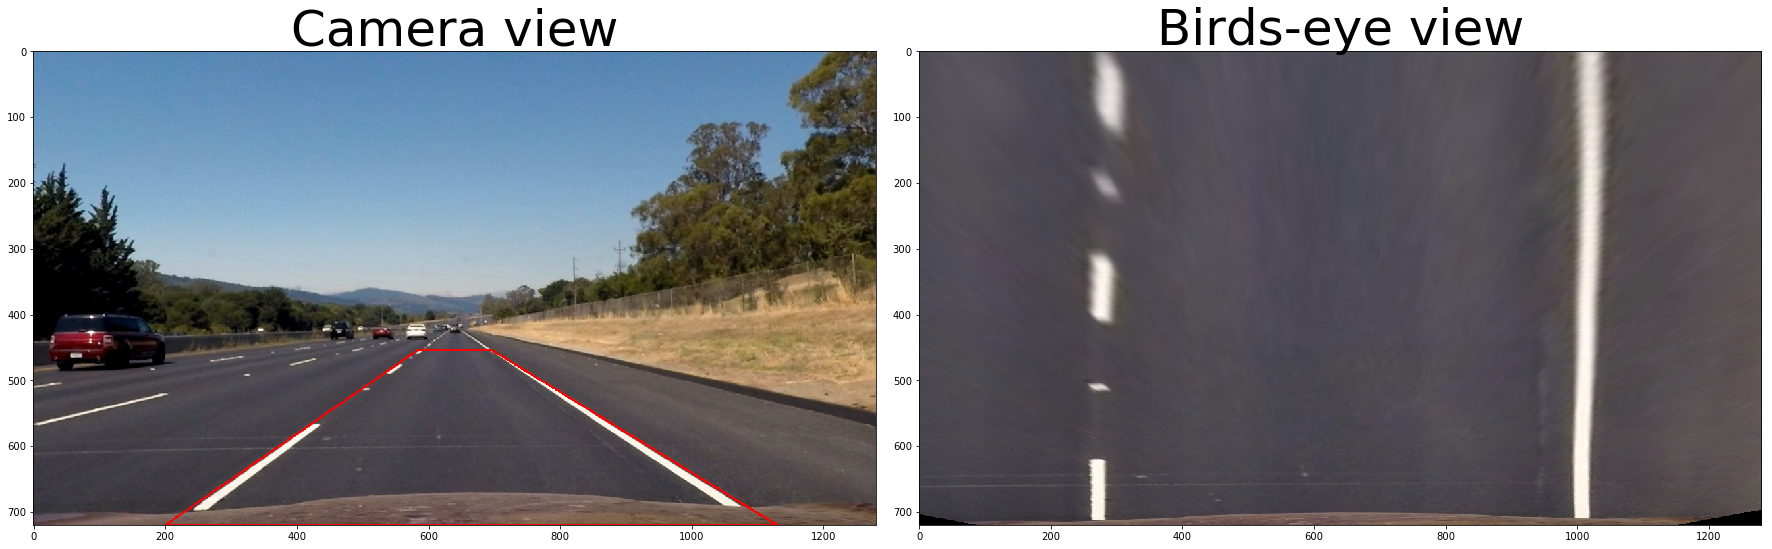

In [7]:
# Visualize transformed perspective on a straight line road image
straight_img = mpimg.imread('test_images/straight_lines2.jpg')
print(straight_img.shape)
undist_straight = cv2.undistort(straight_img, mtx, dist, None, mtx)

warped, straight_draw = transform(undist_straight)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(straight_draw)
ax1.set_title('Camera view', fontsize=50)
ax2.imshow(warped)
ax2.set_title('Birds-eye view', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

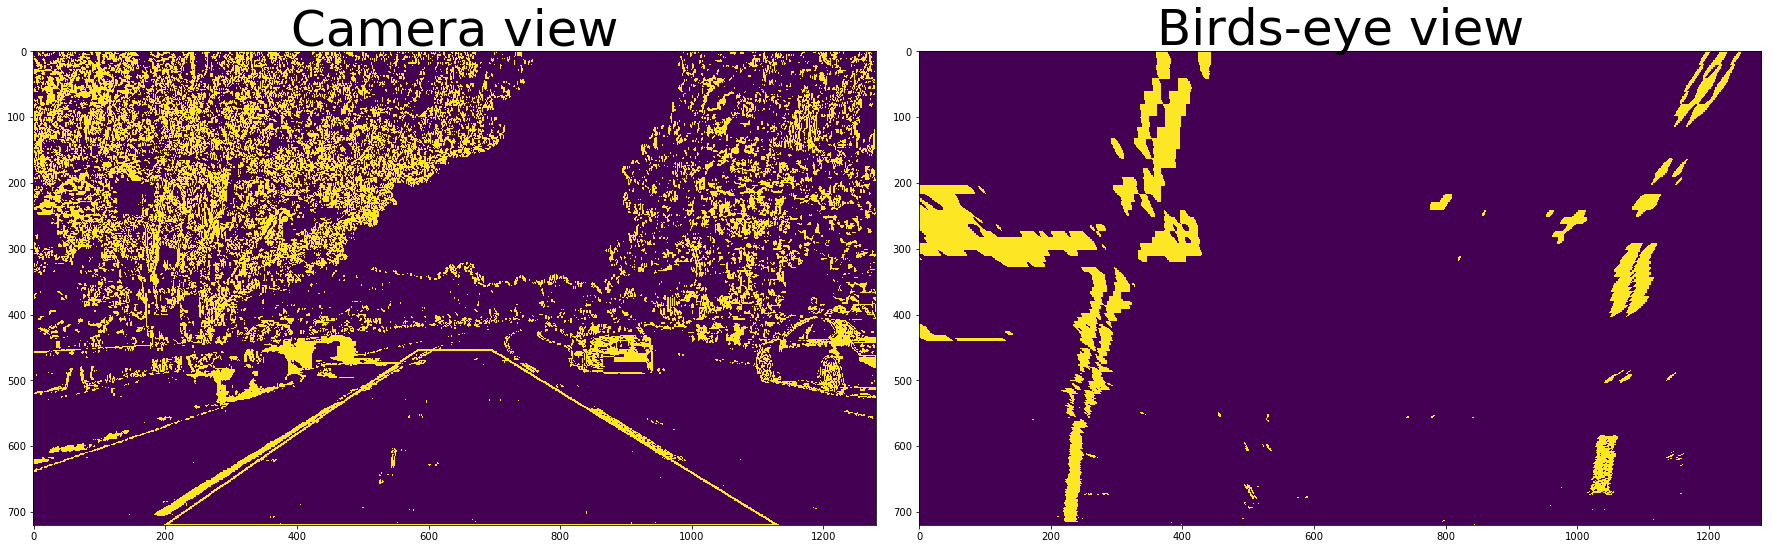

In [8]:
# Transform binary image
binary_warped, binary_draw = transform(binary)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(binary_draw)
ax1.set_title('Camera view', fontsize=50)
ax2.imshow(binary_warped)
ax2.set_title('Birds-eye view', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Detect lane pixels and fit to find the lane boundary.

Text(0.5, 1.0, 'Polynomial search')

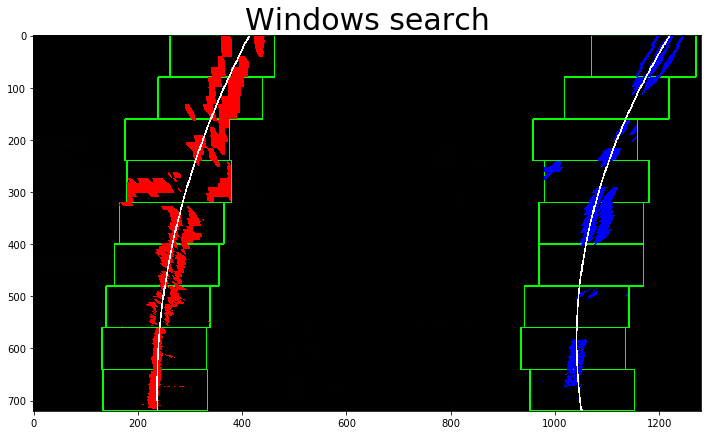

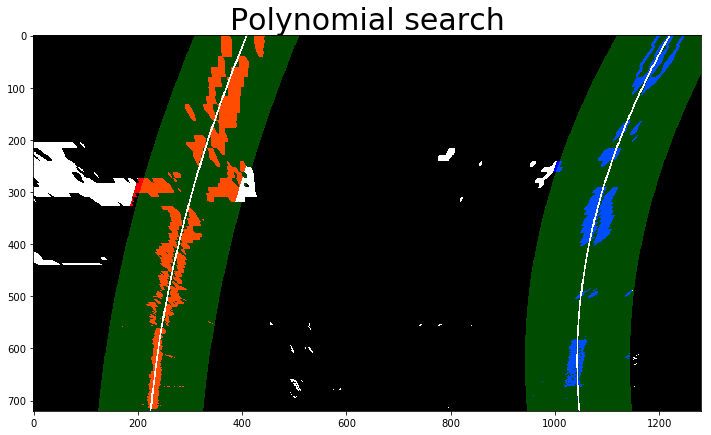

In [9]:
lane = Lane(lane_detected=False)
curve = lane.fit_polynomial(binary_warped)
f, ax1 = plt.subplots(1, 1, figsize=(10, 10))
f.tight_layout()
ax1.imshow(curve)
ax1.set_title('Windows search', fontsize=30)

# After lane is detected for the previous frame
lane.lane_detected = True
curve = lane.fit_polynomial(binary_warped)
f, ax1 = plt.subplots(1, 1, figsize=(10, 10))
f.tight_layout()
ax1.imshow(curve)
ax1.set_title('Polynomial search', fontsize=30)

## Determine the curvature of the lane and vehicle position with respect to center.

In [10]:
def cal_curvature_center(lane, curve):
    # Calculate the radius of curvature in meters for both lane lines
    left_curverad, right_curverad = lane.measure_curvature_real()
    avg_curverad = (left_curverad + right_curverad)/2.0
    dist_to_center = lane.measure_center(curve.shape)
    
    return avg_curverad, dist_to_center

avg_curverad, dist_to_center = cal_curvature_center(lane, curve)
print(avg_curverad, dist_to_center)

2215.945969288455 0.019508779324980782


## Warp the detected lane boundaries back onto the original image.

In [11]:
def transform_inverse(img):
    img_draw = img.copy()
    xsize = img.shape[1]
    ysize = img.shape[0]

    src = np.array(
                [[xsize/5,0],
                 [xsize-xsize/5,0],
                 [xsize-xsize/5,ysize],
                 [xsize/5,ysize]], dtype=np.float32)
    
    dst = np.array(
                [[xsize/2 - 55,ysize*0.63],
                 [xsize/2 + 55,ysize*0.63],
                 [xsize-150,ysize],
                 [200,ysize]], dtype=np.float32)

    # Visualize src points
    if len(img.shape) <= 2:
        color = 1
    else:
        color = [255, 0, 0]
        cv2.line(img_draw, tuple(src[0]), tuple(src[1]), color=color, thickness=2)
        cv2.line(img_draw, tuple(src[1]), tuple(src[2]), color=color, thickness=2)
        cv2.line(img_draw, tuple(src[2]), tuple(src[3]), color=color, thickness=2)
        cv2.line(img_draw, tuple(src[3]), tuple(src[0]), color=color, thickness=2)

    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, (xsize,ysize), flags=cv2.INTER_LINEAR)
    return warped, img_draw

In [12]:
def unwarp_to_original(img, warped):
    road_mask_warped = np.zeros_like(warped)
    for y in range(road_mask_warped.shape[0]):
        left_fitx = lane.left_fit[0]*lane.ploty**2 + lane.left_fit[1]*lane.ploty + lane.left_fit[2]
        right_fitx = lane.right_fit[0]*lane.ploty**2 + lane.right_fit[1]*lane.ploty + lane.right_fit[2]
        road_mask_warped[y][int(left_fitx[y]):int(right_fitx[y])] = [0, 255, 0]
    mask, _ = transform_inverse(road_mask_warped)
    result = cv2.addWeighted(img, 1., mask, 0.3, 0.)
    
    return result

## Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [13]:
def display_text(img, avg_curverad, dist_to_center):
    # Output visual display of numerical estimation of lane curvature and vehicle position
    text1 = "Road curvature: %.2fm" % (avg_curverad)
    if dist_to_center < 0.1:
        text2 = "Car is %.2fm left from center" % (abs(dist_to_center))
    elif dist_to_center > 0.1:
        text2 = "Car is %.2fm right from center" % (abs(dist_to_center))
    else:
        text2 = "Car is at the center"
    cv2.putText(img, text1, (20,100), cv2.FONT_HERSHEY_SIMPLEX, 1.5, color=[255, 255, 255], thickness=3)
    cv2.putText(img, text2, (20,200), cv2.FONT_HERSHEY_SIMPLEX, 1.5, color=[255, 255, 255], thickness=3)
    
    return img

Text(0.5, 1.0, 'Result')

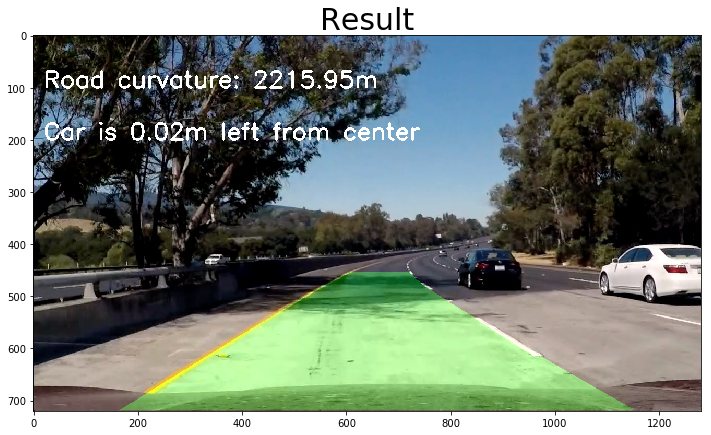

In [14]:
result = unwarp_to_original(img, curve)
avg_curverad, dist_to_center = cal_curvature_center(lane, curve)
result = display_text(result, avg_curverad, dist_to_center)
            
f, ax1 = plt.subplots(1, 1, figsize=(10, 10))
f.tight_layout()
ax1.imshow(result)
ax1.set_title('Result', fontsize=30)

## Test the pipeline on video

In [15]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [16]:
class VideoProcessor:
    
    def __init__(self, lane, objpoints, imgpoints, imgsize):
        self.lane = lane
        _, self.mtx, self.dist, _, _ = cv2.calibrateCamera(objpoints, imgpoints, imgsize, None, None)
        
    def process_image(self, input_image):
        image = input_image.copy()
        undist_image = cv2.undistort(image, self.mtx, self.dist, None, self.mtx)
        binary, _ = cal_binary(undist_image, s_thresh=(180, 255), sx_thresh=(20, 100))
        binary_warp, _ = transform(binary)
        curve = self.lane.fit_polynomial(binary_warp)
        avg_curverad, dist_to_center = cal_curvature_center(self.lane, curve)
        unwarp = unwarp_to_original(undist_image, curve)
        output = display_text(unwarp, avg_curverad, dist_to_center)
        
        output = np.concatenate((curve, output), axis=0)
        
        return output

In [17]:
from lane import *
lane = Lane()
processor = VideoProcessor(lane, objpoints, imgpoints, (1280, 720))

project_output = 'project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(processor.process_image)
%time white_clip.write_videofile(project_output, audio=False)

t:   0%|          | 2/1260 [00:00<01:34, 13.25it/s, now=None]

Moviepy - Building video project_video_output.mp4.
Moviepy - Writing video project_video_output.mp4



Moviepy - Done !
Moviepy - video ready project_video_output.mp4
CPU times: user 16min 35s, sys: 10.2 s, total: 16min 45s
Wall time: 2min 56s


In [18]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_output))

In [19]:
# objpoints, imgpoints = calibrate_camera()
# Test the computed calibration matrix on a chessboard image
lane = Lane()
processor = VideoProcessor(lane, objpoints, imgpoints, (1280, 720))

challenge_output = 'challenge_video_output.mp4'
clip1 = VideoFileClip("challenge_video.mp4")
white_clip = clip1.fl_image(processor.process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(challenge_output, audio=False)

t:   0%|          | 2/485 [00:00<00:33, 14.59it/s, now=None]

Moviepy - Building video challenge_video_output.mp4.
Moviepy - Writing video challenge_video_output.mp4



Moviepy - Done !
Moviepy - video ready challenge_video_output.mp4
CPU times: user 4min 45s, sys: 6.56 s, total: 4min 52s
Wall time: 1min 3s


In [20]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

In [21]:
# objpoints, imgpoints = calibrate_camera()
# Test the computed calibration matrix on a chessboard image
lane = Lane()
processor = VideoProcessor(lane, objpoints, imgpoints, (1280, 720))

harder_challenge_output = 'harder_challenge_video_output.mp4'
clip1 = VideoFileClip("harder_challenge_video.mp4")
white_clip = clip1.fl_image(processor.process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(challenge_output, audio=False)

t:   0%|          | 2/1199 [00:00<01:39, 11.99it/s, now=None]

Moviepy - Building video challenge_video_output.mp4.
Moviepy - Writing video challenge_video_output.mp4



Moviepy - Done !
Moviepy - video ready challenge_video_output.mp4
CPU times: user 11min, sys: 14.7 s, total: 11min 15s
Wall time: 2min 44s


In [22]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(harder_challenge_output))